In [1]:
# This magic makes plots appear in the browser
%matplotlib notebook
import matplotlib.pyplot as plt

# Problema Direto

Esse exemplo mostra como resolver o problema direto de simulação da onda acústica. Foi escolhido um meio simples dividido em duas camadas, uma superior onde a velocidade de propagação é de 2,5, e uma profunda com velocidade de 3,5.

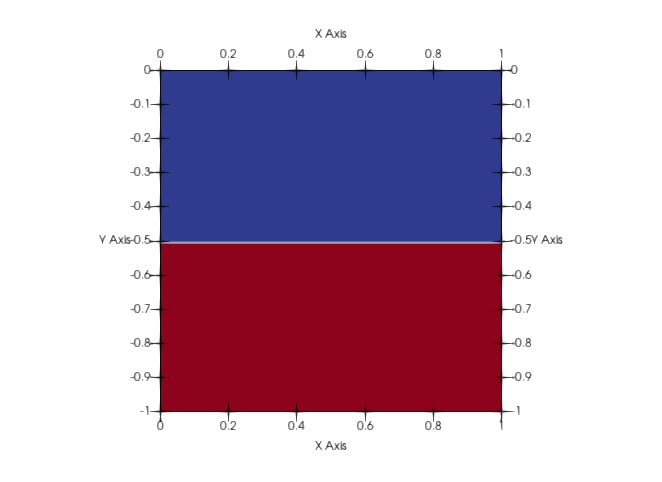

$$\frac{1}{c^2}\frac{\partial^2 u}{\partial t^2} - \nabla^2 u = s \quad \text{no interior do domínio} \quad (\text{1a})$$ 

$$\nabla u \cdot n = 0 \quad \text{no contorno} \qquad \qquad \qquad \quad \; \, (\text{1b})$$

Para a integração no tempo, será usado um esquema simplético que avança a meios passos de tempo. Antes disso, se rescreve o problema como:

$$\frac{\partial u}{\partial t} = -v \qquad \:\:\ \qquad(\text{2a})$$

$$\frac{1}{c^2}\frac{\partial v}{\partial t} + \nabla^2 u = - s \qquad (\text{2b})$$

$$s = f_{rick}(t)\delta(x-x_0) \qquad \text{(2c)}$$

onde $f_{rick}$ é um sinal do tipo *Ricker* com frequência central de 10Hz exercido sobre o ponto $x_0 = (0.5, -0.02) \;$. Discretizando no tempo obtemos:

$$u_{n+{\frac{1}{2}}} = u_n - \frac{\Delta t}{2}v_n \qquad \qquad \qquad \quad \;(\text{3a})$$

$$v_{n+1} = v_n - \Delta t c^2(\nabla^2u_{n+\frac{1}{2}} + s_{n+\frac{1}{2}}) \qquad (\text{3b})$$

Diferentemente do método das diferenças finitas em que se resolve as equação originais diretamente, no método dos elementos finitos se resolve a chamada **forma fraca** do problema, escrita em forma integral. Como somente (3b) possui derivada espacial, o problema fica:

$$ \qquad \qquad \quad \qquad \qquad  u_{n+\frac{1}{2}} = u_n - \frac{\Delta t}{2}v_n \qquad \qquad \qquad \qquad \qquad \; \,(\text{4a})$$

$$\int_\Omega v_{n+1} \phi \,\mathrm{d}\Omega= \int_\Omega v_n \phi \, \mathrm{d}\Omega + \Delta t  \int_\Omega c^2\nabla u \cdot \nabla \phi \, \mathrm{d}\Omega - \Delta t  \int_\Omega c^2 s \phi \, \mathrm{d}\Omega \qquad (\text{4b})$$

onde $\Omega$ é o domínio e $\phi$ é denominada função teste. 

Finalmente começamos o script carregando o Firedrake e criando a malha:

In [2]:
from firedrake import *
import numpy as np

nelx, nely = 100, 100
Lx, Ly = 1, -1

mesh = RectangleMesh(nelx, nely, Lx, Ly)

Escolhemos funções lineares e contínuas para compor a base da nossa solução:

In [3]:
V = FunctionSpace(mesh, 'CG', 1)
u = Function(V)
v = Function(V)
s = Function(V)

phi = TestFunction(V)

O Modelo de velocidades em particular pode ser criado utilizando uma expressão condicional:

<IPython.core.display.Javascript object>


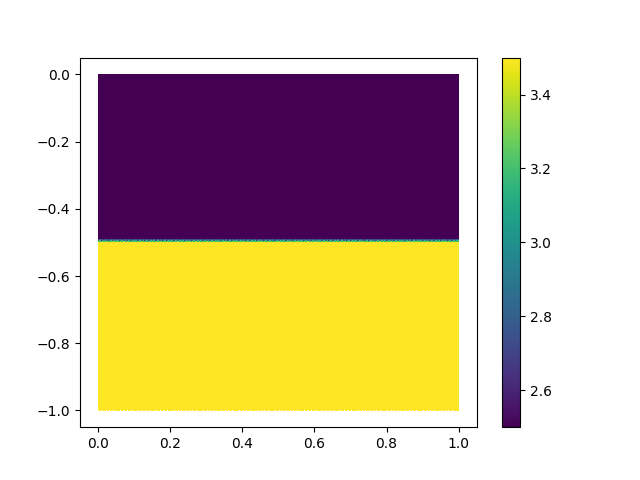

In [4]:
x, y = SpatialCoordinate(mesh)
c2 = Function(V).interpolate(conditional(y > Ly/2, Constant(2.5**2), Constant(3.5**2)))
                             
# Mostra o modelo de velocidades                           
try:
  fig, axes = plt.subplots()
  colors = tripcolor(interpolate(sqrt(c2), V), axes=axes)
  fig.colorbar(colors)
except Exception as e:
  warning("Cannot plot figure. Error msg: '%s'" % e)

try:
  fig.show()
except Exception as e:
  warning("Cannot show figure. Error msg: '%s'" % e)

Caso se deseje salvar a solução para visualização num software externo, é possível salvar os dados num formato diretamente interpretável pelo *software* ParaView:

In [5]:
output = File('output/saida.pvd')
output.write(u)

A duração do evento é definida como 1, com passo de tempo de 0.001. Importa-se também uma função *ricker* para simular a fonte agindo no ponto (0.5, -0.02), além de uma função auxiliar para simular a ação de uma fonte pontual:

<IPython.core.display.Javascript object>


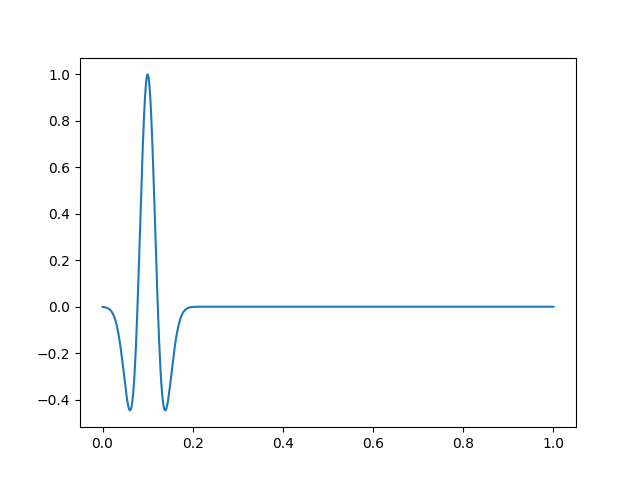

In [6]:
T = 1
nt = 1000
dt = T/nt
t = 0
step = 0

f0 = 10
x0 = [0.5, -0.02]

from utils import ricker, disturb_dof

# Mostra o sinal da fonte ao longo do tempo
t0 = np.linspace(0, T, nt)
try:
  fig2, axes = plt.subplots()
  axes.plot(t0, ricker(f0, t0))
except Exception as e:
  warning("Cannot plot figure. Error msg: '%s'" % e)

try:
  fig2.show()
except Exception as e:
  warning("Cannot show figure. Error msg: '%s'" % e)

Além disso, registra-se os pontos superiores correspondentes à posição dos receptores:

In [7]:
coordinates = mesh.coordinates.dat.data
receivers = coordinates[coordinates[:,1]==0][:-1]

# Inicia registro do tiro
shot_record = u.at(receivers)

Inicia-se então o laço temporal:

In [8]:
while t <= T:
    step += 1
    
    # Expressão (4a)    
    u -= dt / 2 * v
    t += dt / 2
    
    # Prepara fonte
    disturb_dof(s, x0, h=ricker(f0, t))
    # Expressão (4b)
    v += assemble(dt * c2 * (inner(nabla_grad(u), nabla_grad(phi)) - s*phi)* dx) / assemble(phi*dx)
    
    # Expressão (4a) novamente    
    u -= dt / 2 * v
    t += dt / 2
    
    # Registra sinal nos receptores
    shot_record = np.vstack((shot_record, u.at(receivers)))
    
    if step % 10 == 0:
        output.write(u, time=t)
        if step % 50 == 0:
            print("resolvendo para tempo t=", t)
    

resolvendo para tempo t= 0.05000000000000004
resolvendo para tempo t= 0.10000000000000007
resolvendo para tempo t= 0.1500000000000001
resolvendo para tempo t= 0.20000000000000015
resolvendo para tempo t= 0.25000000000000017
resolvendo para tempo t= 0.3000000000000002
resolvendo para tempo t= 0.35000000000000026
resolvendo para tempo t= 0.4000000000000003
resolvendo para tempo t= 0.45000000000000034
resolvendo para tempo t= 0.5000000000000003
resolvendo para tempo t= 0.5499999999999948
resolvendo para tempo t= 0.5999999999999893
resolvendo para tempo t= 0.6499999999999838
resolvendo para tempo t= 0.6999999999999783
resolvendo para tempo t= 0.7499999999999728
resolvendo para tempo t= 0.7999999999999673
resolvendo para tempo t= 0.8499999999999618
resolvendo para tempo t= 0.8999999999999563
resolvendo para tempo t= 0.9499999999999508
resolvendo para tempo t= 0.9999999999999453


Por fim, conferimos o registro do tiro:

<IPython.core.display.Javascript object>


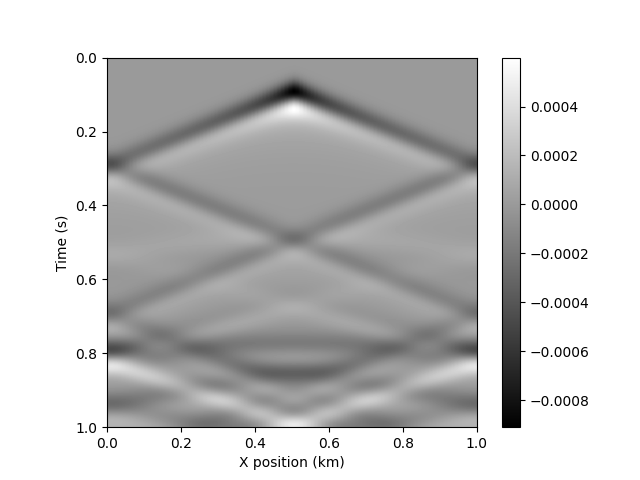

In [9]:
# Mostra o registro do tiro                           
try:
  fig3, axes = plt.subplots()
  colors = plt.imshow(shot_record, extent=[0, 1, 1, 0], cmap='gray')
  plt.xlabel('X position (km)')
  plt.ylabel('Time (s)')
  fig3.colorbar(colors)
except Exception as e:
  warning("Cannot plot figure. Error msg: '%s'" % e)

try:
  fig3.show()
except Exception as e:
  warning("Cannot show figure. Error msg: '%s'" % e)